<a href="https://colab.research.google.com/github/ydsyvn/Spray-Wall-Boulder-Genration/blob/main/final_project_hold_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h1 dir="rtl">פרוייקט סיום - סגמנטצית אחיזות טיפוס - עידו סיון</h1>



לקחתי את הנתונים מפה:
[github](https://github.com/mcloses/smear-beta)

כתבה שימושית: [Modify Dataset class for COCO data](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)

In [1]:
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
# Mount drive and get dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <h2 > visualizing the dataset </h2>

<ipython-input-3-82dfb903ca83>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


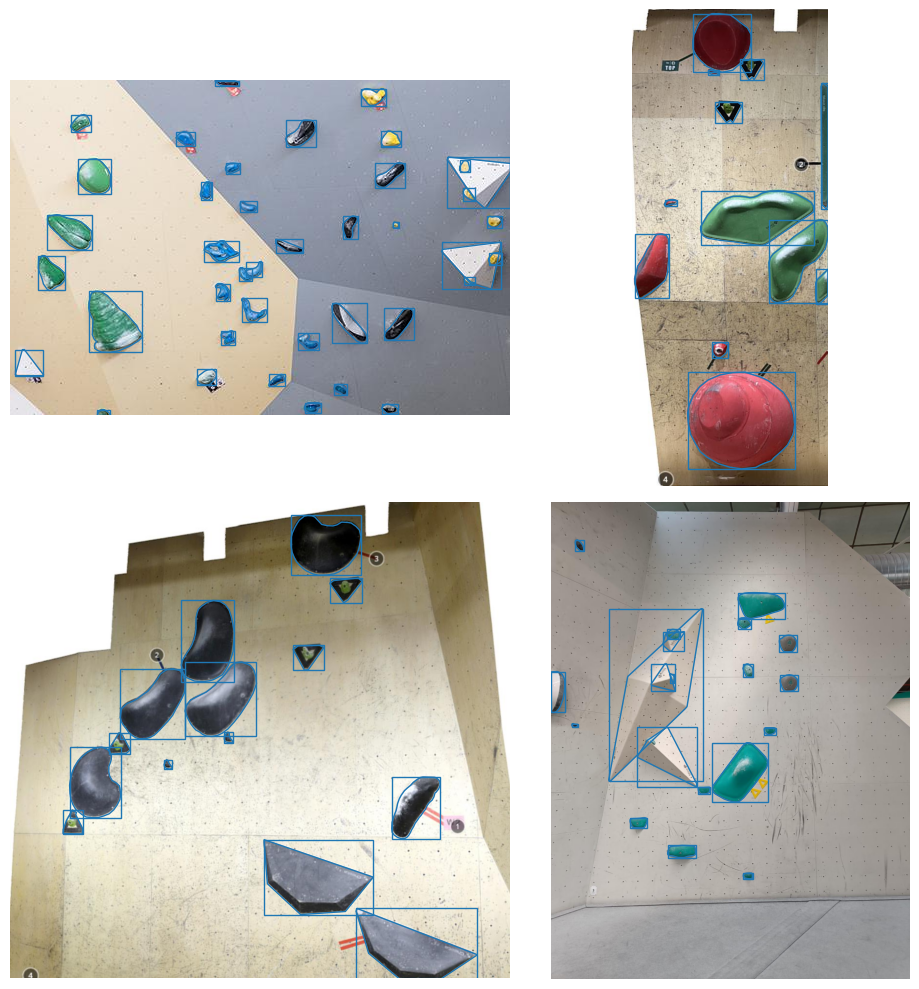

In [3]:
import matplotlib.patches as patches
import cv2

def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Define a default color map if none is provided
        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            #category_id = ann['category_id']
            #color = colors(category_id % 10)
            color=colors(0)

            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open('/content/drive/MyDrive/Data/hold segmentation/train.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "/content/drive/MyDrive/Data/hold segmentation/segmentation images/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'both'
display_images_with_coco_annotations(random_image_files, annotations, display_type)



#display_images_with_coco_annotations(['livecell_test_images/SKOV3_Phase_F4_2_03d00h00m_4.tif'], annotations, display_type)

## <h2 > pytorch </h2>

In [ ]:
from pycocotools.coco import COCO

import torch
import torch.nn as nn
from torchvision.transforms import functional as F

from torch.utils.data import DataLoader

from sklearn.metrics import jaccard_score
from torchvision.transforms import functional as F
from sklearn.metrics import accuracy_score

from torchvision.models.segmentation import fcn_resnet50
import torchvision.models as models

import torch.optim as optim

###<h3> resize the images</h3>

In [ ]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, new_size=(640, 480)):
        self.image_dir = image_dir
        self.new_size = new_size
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Load the image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Load the masks
        masks = np.zeros([img_info['height'], img_info['width']])
        for ann in anns:
            mask = coco.annToMask(ann) * 255
            masks = np.maximum(masks, mask)
        masks = Image.fromarray(masks)

        # Resize image and masks
        img = F.resize(img, self.new_size)
        masks = F.resize(masks, self.new_size)

        # Convert to PyTorch tensors
        img = F.to_tensor(img)
        masks = torch.from_numpy(np.array(masks)).long()

        masks = (masks > 0).long()

        return img, masks

    def __len__(self):
        return len(self.ids)


In [ ]:
train_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/train.json')


loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [ ]:
val_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/test.json')


loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


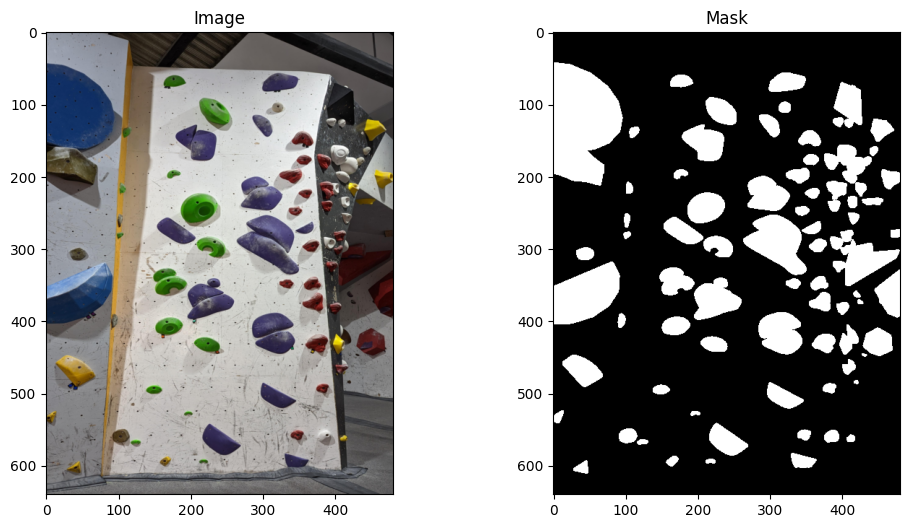

In [ ]:


# Select a random image
index = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[index]

# Convert tensors to numpy arrays for visualization
img = img.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()

# Plot the image and the mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title('Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')

plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### <h3> YOLO </h3>


In [ ]:
!pip install yolov5

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import json
import os
from PIL import Image
from yolov5.models.yolo import Model


In [ ]:

# Load the json files
with open('/content/drive/MyDrive/Data/hold segmentation/train.json', 'r') as f:
    train_annotations = json.load(f)

with open('/content/drive/MyDrive/Data/hold segmentation/test.json', 'r') as f:
    test_annotations = json.load(f)

# Define your custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, img_folder, transforms=None):
        self.annotations = annotations
        self.img_folder = img_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        print(idx)
        # Load the image
        img_path = os.path.join(self.img_folder, str(self.annotations[idx]['image_id']) + '.jpg')
        img = Image.open(img_path).convert("RGB")

        # Load the bounding boxes
        boxes = [self.annotations[idx]['bbox']]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # There is only one class
        labels = torch.ones((1,), dtype=torch.int64)

        # Load the image area
        area = torch.as_tensor([self.annotations[idx]['area']], dtype=torch.float32)

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.annotations)

# Define the transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Create the datasets
train_dataset = CustomDataset(train_annotations, '/content/drive/MyDrive/Data/hold segmentation/segmentation images', data_transforms)
test_dataset = CustomDataset(test_annotations, '/content/drive/MyDrive/Data/hold segmentation/segmentation images', data_transforms)



Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
        reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

Du

In [ ]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4)


In [ ]:
# Load a pre-trained model
model = Model(cfg='yolov5s.yaml', ch=3, nc=1)  # nc is the number of classes
model = model.autoshape()  # for autoshaping of PIL/cv2/np inputs and NMS


FileNotFoundError: [Errno 2] No such file or directory: 'yolov5s.yaml'

In [ ]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in train_dataloader:
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        output = model(images, targets)   # Returns losses and detections


21



KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-33-9173b0b700c1>", line 18, in __getitem__
    img_path = os.path.join(self.img_folder, str(self.annotations[idx]['image_id']) + '.jpg')
KeyError: 2


In [ ]:
# For inference
model.eval()
with torch.no_grad():
    for images, _ in test_dataloader:
        prediction = model(images)       # Returns predictions


In [ ]:
# Install YOLOv5
!pip install -q yolov5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.1/715.1 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7

In [ ]:

# Import libraries
import torch
import torchvision
from yolov5.utils.downloads import attempt_download



# Load the dataset
from pathlib import Path
import torch.utils.data

In [ ]:
# Download pre-trained YOLOv5 weights
weights = attempt_download('yolov5s.pt')

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-19 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
import os
import json


images_dir = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'

with open('/content/drive/MyDrive/Data/hold segmentation/train.json') as f:
    train_annotations = json.load(f)

with open('/content/drive/MyDrive/Data/hold segmentation/test.json') as f:
   test_annotations = json.load(f)

# Load training data
train_imgs = [os.path.join(images_dir, x['file_name']) for x in train_annotations]
train_targets = [{k: v for k, v in x.items() if k != 'file_name'} for x in train_annotations]

train_dataset = CocoDataset(train_imgs, train_targets)

# Load test data
test_imgs = [os.path.join(images_dir, x['file_name']) for x in test_annotations]
test_targets = [{k: v for k, v in x.items() if k != 'file_name'} for x in test_annotations]

test_dataset = CocoDataset(test_imgs, test_targets)


FileNotFoundError: Couldn't find any class folder in /content/drive/MyDrive/Data/hold segmentation/segmentation images.

In [ ]:
# Fine-tune the model on the training set
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

In [ ]:
# Define optimizer and loss fxn
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(10):

    train_loss = 0

    for imgs, targets in train_loader:

        optimizer.zero_grad()

        outputs = model(imgs)

        # Compute loss
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print only loss
    avg_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{10} | Loss: {avg_loss:.4f}')

TypeError: list indices must be integers or slices, not str

In [ ]:
# Make predictions on the test set
results = model(test_dataset)

In [ ]:
# Save the fine-tuned model
torch.save(model, 'my_yolo.pt')

# Load the model and make predictions
model = torch.load('my_yolo.pt')

In [ ]:
import cv2
img = cv2.imread('/path/to/test.jpg')
results = model(img)

### <h3> transfer learning </h3>


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks.unsqueeze(1).float())
            total_loss += loss.item()

            # Calculate accuracy
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get pixel probabilities
            preds = (preds > 0.5).float()  # Binarize predictions
            accuracy = accuracy_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten())
            total_accuracy += accuracy

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy


In [ ]:
# Load the pre-trained weights
pretrained_weights = fcn_resnet50(pretrained=True).state_dict()

# Create a new model
model = fcn_resnet50(pretrained=False, num_classes=1)  # Change num_classes to 1

# Load the weights into the new model, excluding the final layer
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict and "classifier" not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)


<All keys matched successfully>

In [ ]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.classifier.parameters():
    param.requires_grad = True


In [ ]:
model = model.to(device)


In [ ]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Use Binary Cross Entropy loss for binary segmentation
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss which combines a Sigmoid layer and the BCELoss in one single class


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [ ]:
acc_history = []
loss_history = []

# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    for images, masks in train_loader:
        # Move data to the correct device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks.unsqueeze(1).float())  # Convert masks to float

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    acc_history.append(val_accuracy)
    loss_history.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacty of 39.56 GiB of which 84.81 MiB is free. Process 51223 has 39.47 GiB memory in use. Of the allocated memory 38.79 GiB is allocated by PyTorch, and 178.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### <h3> predict </h3>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_display(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = F.resize(image, (640, 480))  # Adjust the size if necessary
    image = F.to_tensor(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)['out']
    prediction = output.argmax(1).squeeze().cpu().numpy()

    # Load the original image
    original_image = Image.open(image_path)

    # Create a mask image from the prediction
    mask = Image.fromarray(prediction.astype(np.uint8) * 255)

    # Overlay the mask on the original image
    overlay = Image.blend(original_image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

    # Display the overlay
    plt.imshow(overlay)
    plt.show()


In [ ]:
path_to_image = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/Img_2023_12_10_12_00_59.jpeg'
predict_and_display(model, path_to_image, device)

ValueError: images do not match

In [ ]:
def predict_random_image(model, folder_path, device):
    # Select a random image from the folder
    image_path = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_path)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = F.resize(image, (640, 480))  # Adjust the size if necessary
    image = F.to_tensor(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)['out']
    prediction = output.argmax(1).squeeze().cpu().numpy()

    # Load the original image
    original_image = Image.open(image_path)

    # Create a mask image from the prediction
    mask = Image.fromarray(prediction.astype(np.uint8) * 255)

    # Display the original image and the mask side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.show()


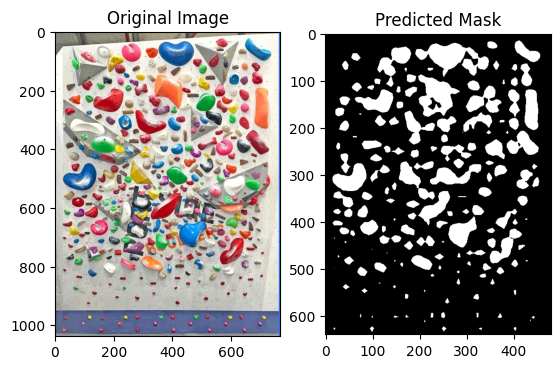

In [ ]:
path_to_folder = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/'
predict_random_image(model, path_to_folder, device)

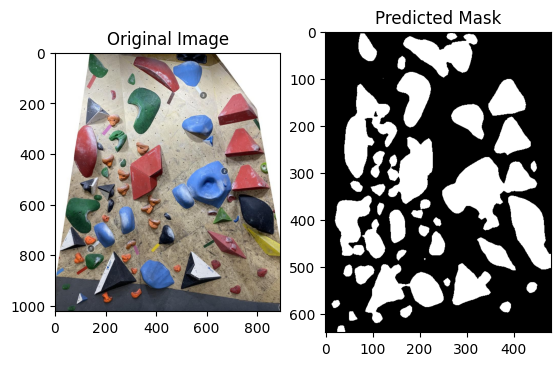

In [ ]:
path_to_folder = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'
predict_random_image(model, path_to_folder, device)

### <h3> CNN model</h3>

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
num_classes = 2

In [ ]:
UNet_model = UNet(num_classes).to(device)

In [ ]:
# Create a DataLoader for your dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
# Use Binary Cross Entropy loss for binary segmentation
criterion = nn.BCELoss()

# Use Adam optimizer
optimizer = torch.optim.Adam((UNet_model).parameters(), lr=0.001)

In [ ]:
epochs = 5

In [ ]:

loss_history = []

for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = UNet_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    torch.cuda.empty_cache()
    loss = loss.item()

    loss_history.append(loss)
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.34 GiB. GPU 0 has a total capacty of 39.56 GiB of which 2.07 GiB is free. Process 51223 has 37.48 GiB memory in use. Of the allocated memory 32.54 GiB is allocated by PyTorch, and 4.46 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## <h2> Detectron 2 </h2>

In [4]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15359, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 15359 (delta 31), reused 43 (delta 16), pack-reused 15275
Receiving objects: 100% (15359/15359), 6.23 MiB | 24.83 MiB/s, done.
Resolving deltas: 100% (11146/11146), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

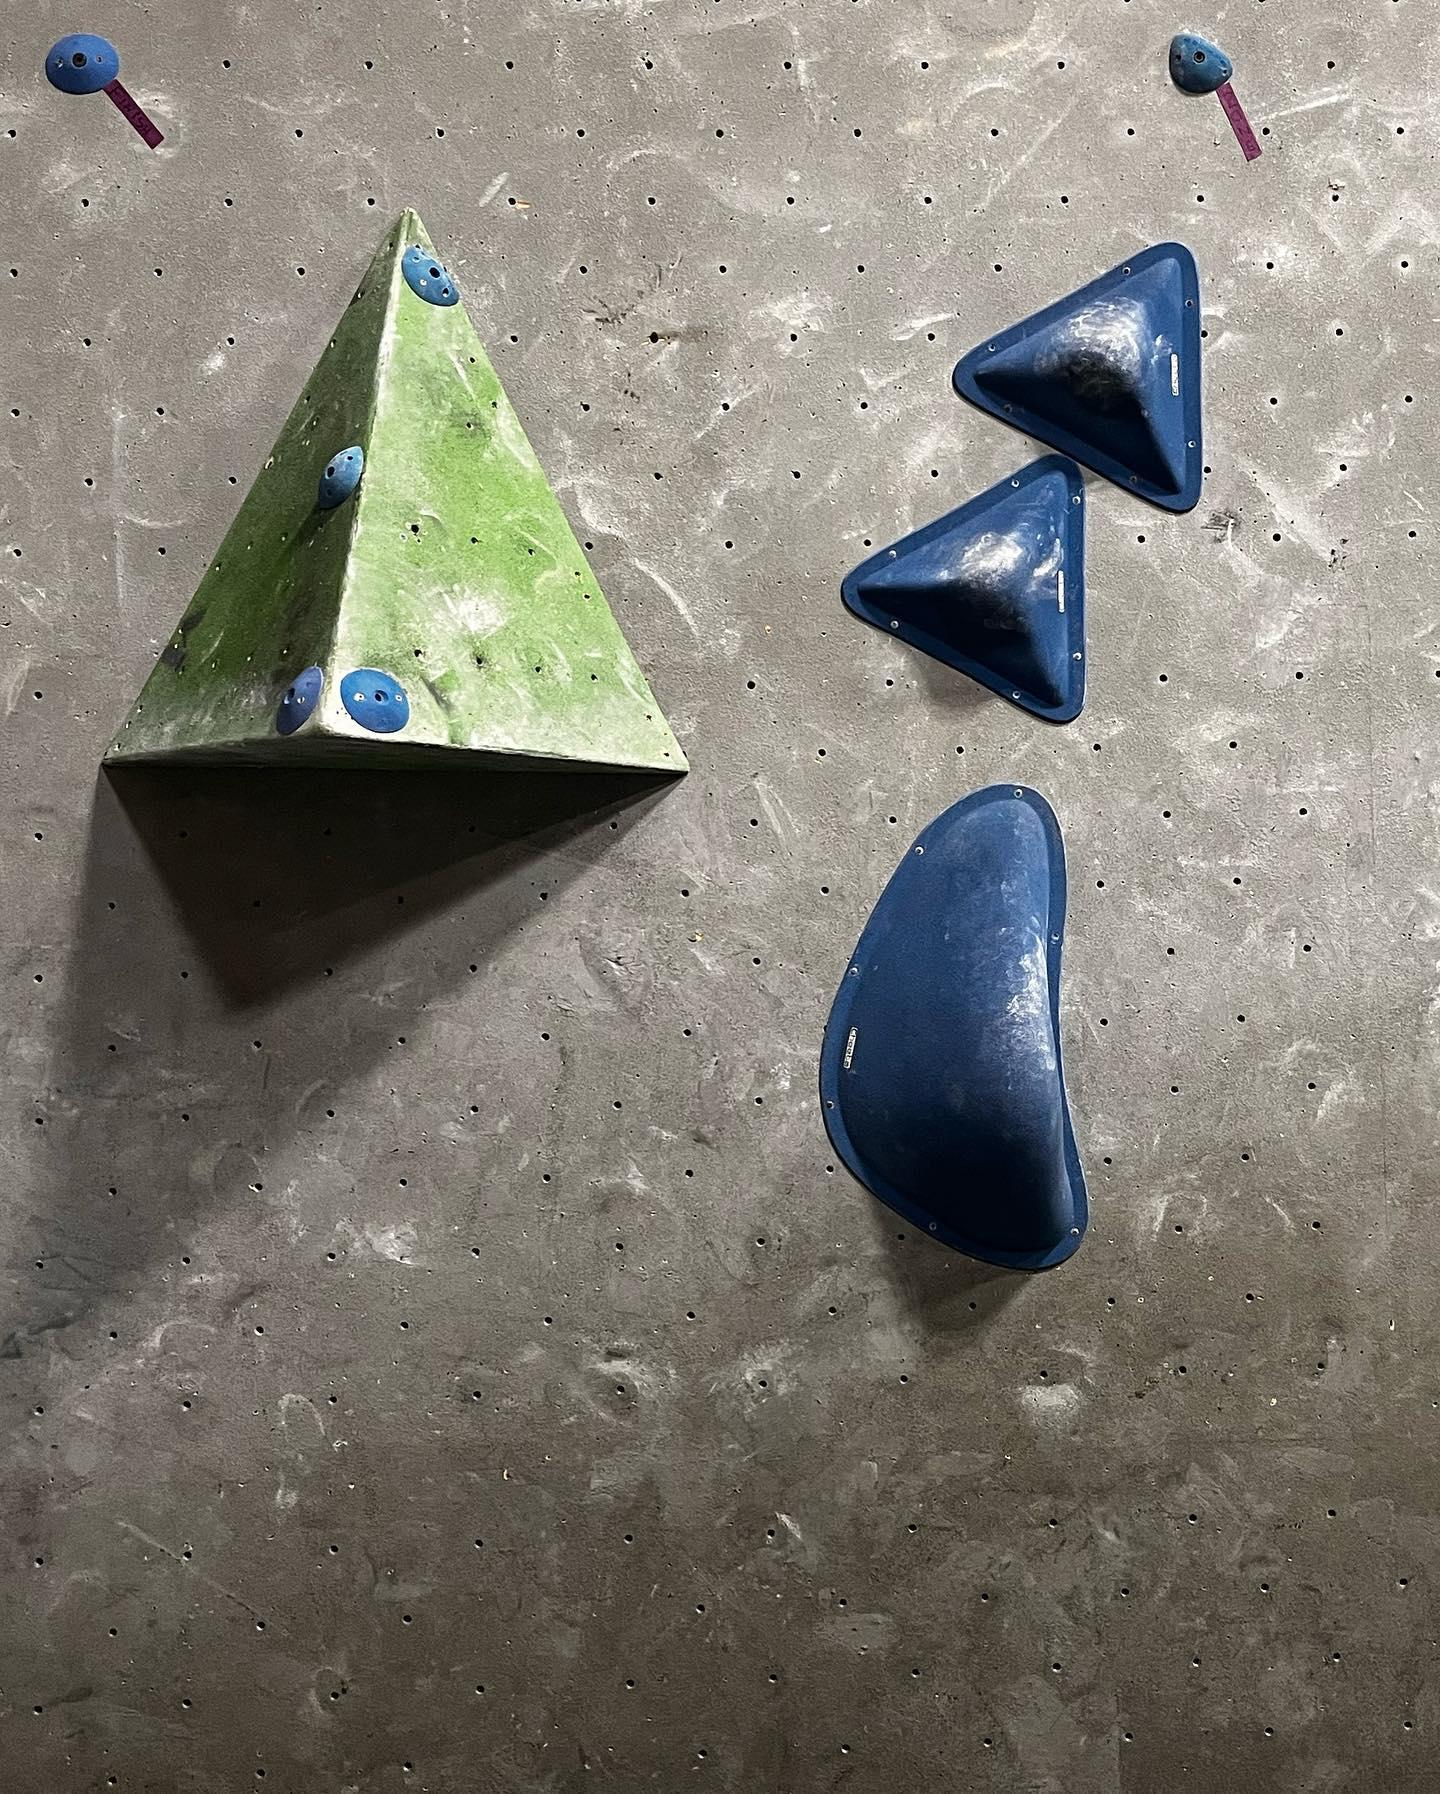

In [8]:
im = cv2.imread("/content/drive/MyDrive/Data/hold segmentation/segmentation images/10.jpg")
cv2_imshow(im)

### <h3> Fine tune on custom dataset </h3>

In [14]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_dataset", {}, "/content/drive/MyDrive/Data/hold segmentation/train.json", "/content/drive/MyDrive/Data/hold segmentation/segmentation images")
register_coco_instances("val_dataset", {}, "/content/drive/MyDrive/Data/hold segmentation/test.json", "/content/drive/MyDrive/Data/hold segmentation/segmentation images")


In [15]:
train_metadata = MetadataCatalog.get("train_dataset")
train_dataset_dicts = DatasetCatalog.get("train_dataset")

WARNING [02/26 10:55:48 d2.data.datasets.coco]: /content/drive/MyDrive/Data/hold segmentation/train.json contains 4445 annotations, but only 4440 of them match to images in the file.
[02/26 10:55:48 d2.data.datasets.coco]: Loaded 109 images in COCO format from /content/drive/MyDrive/Data/hold segmentation/train.json


In [16]:
val_metadata = MetadataCatalog.get("val_ds")
val_dataset_dicts = DatasetCatalog.get("val_ds")

[02/26 10:55:53 d2.data.datasets.coco]: Loaded 28 images in COCO format from /content/drive/MyDrive/Data/hold segmentation/test.json


In [17]:
from matplotlib import pyplot as plt

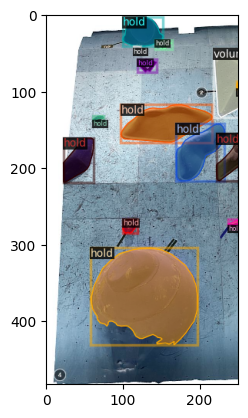

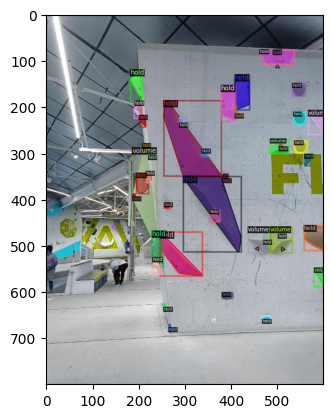

In [20]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [22]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Data/hold segmentation/Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.



In [23]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[02/26 11:04:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 195MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [24]:
trainer.train() #Start the training process

[02/26 11:05:03 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/26 11:05:16 d2.utils.events]:  eta: 0:02:16  iter: 19  total_loss: 4.962  loss_cls: 1.163  loss_box_reg: 0.7649  loss_mask: 0.6882  loss_rpn_cls: 2.161  loss_rpn_loc: 0.2325    time: 0.3899  last_time: 0.1820  data_time: 0.1546  last_data_time: 0.0030   lr: 9.7405e-06  max_mem: 2579M
[02/26 11:05:25 d2.utils.events]:  eta: 0:02:09  iter: 39  total_loss: 3.646  loss_cls: 1.007  loss_box_reg: 0.7745  loss_mask: 0.6608  loss_rpn_cls: 0.8475  loss_rpn_loc: 0.234    time: 0.3565  last_time: 0.1854  data_time: 0.0871  last_data_time: 0.0054   lr: 1.9731e-05  max_mem: 2579M
[02/26 11:05:32 d2.utils.events]:  eta: 0:02:04  iter: 59  total_loss: 2.386  loss_cls: 0.805  loss_box_reg: 0.7083  loss_mask: 0.6173  loss_rpn_cls: 0.1502  loss_rpn_loc: 0.1447    time: 0.3506  last_time: 0.1866  data_time: 0.0904  last_data_time: 0.0045   lr: 2.972e-05  max_mem: 2670M
[02/26 11:05:37 d2.utils.events]:  eta: 0:01:56  iter: 79  total_loss: 2.205  loss_cls: 0.6224  loss_box_reg: 0.6872  loss_mask: 0.54

Save the config file, for potential future use

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [27]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/Data/hold segmentation/Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

### <h3> Test and validate the model </h3>

In [29]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/26 11:10:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Data/hold segmentation/Models/model_final.pth ...


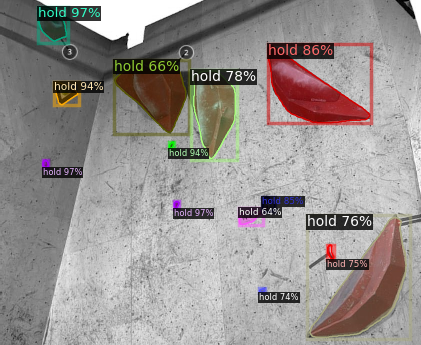

In [30]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [33]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("val_dataset", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val_dataset")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/26 11:11:46 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/26 11:11:46 d2.data.datasets.coco]: Loaded 28 images in COCO format from /content/drive/MyDrive/Data/hold segmentation/test.json
[02/26 11:11:46 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    hold    | 1381         |   volume   | 76           |
|            |              |            |              |
|   total    | 1457         |            |              |
[02/26 11:11:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/26 11:11:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 11:11:46 d2.data.common]: Serializing 28 elements to byte tensors and concaten

**Load a new image and segment it.**

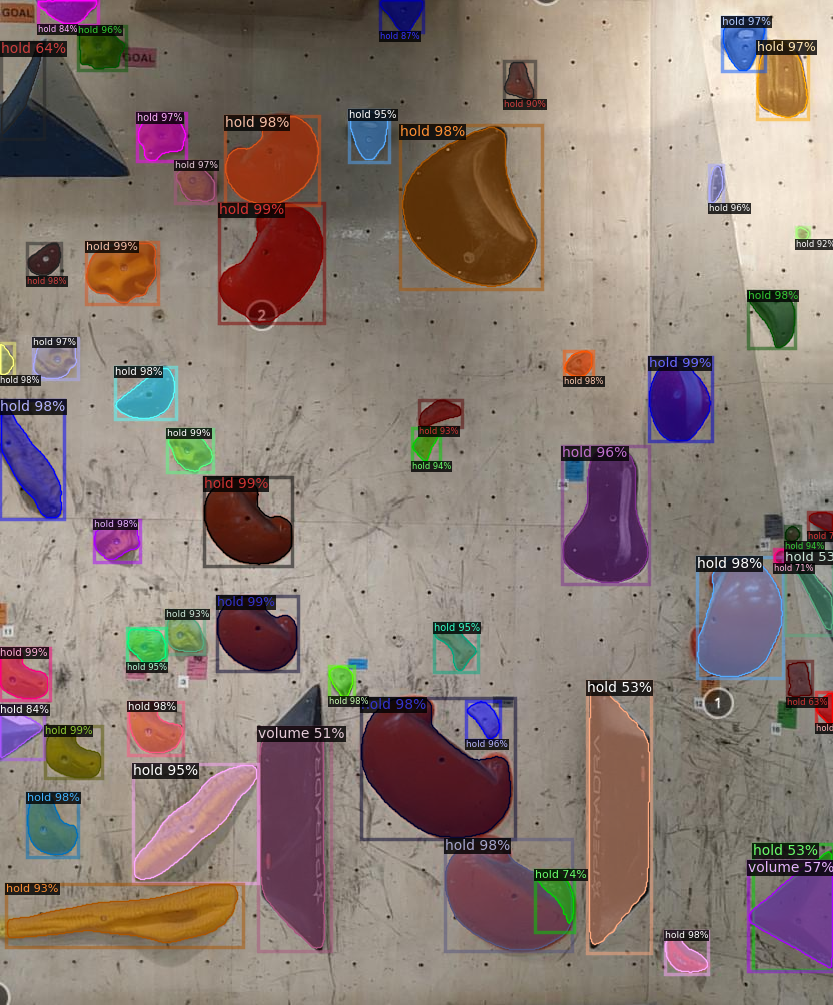

In [37]:
new_im = cv2.imread("/content/drive/MyDrive/Data/hold segmentation/segmentation images/111.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


## <h1> keras </h1>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import cv2

In [ ]:

# Path to the annotation file
train_ann_file = '/content/drive/MyDrive/Data/hold segmentation/train.json'
val_ann_file = '/content/drive/MyDrive/Data/hold segmentation/test.json'

# Create a COCO object
train_ds = COCO(train_ann_file)
val_ds = COCO(val_ann_file)

images = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [ ]:
images = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'

In [ ]:


class CocoDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, target_size=(128, 128), batch_size=32, shuffle=True):
        'Initialization'
        self.dataset = dataset
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset.imgs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.dataset.imgs.keys()[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset.imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size, *self.target_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = cv2.resize(cv2.imread(self.dataset.loadImgs(ID)[0]['file_name']), self.target_size)

            # Store class
            annIds = self.dataset.getAnnIds(imgIds=ID)
            anns = self.dataset.loadAnns(annIds)
            mask = np.zeros((*self.target_size))
            for ann in anns:
                mask = np.maximum(mask, cv2.resize(self.dataset.annToMask(ann), self.target_size))
            y[i] = mask

        return X, y


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def conv2d_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    return x

def create_model(input_shape, n_filters=64, n_classes=2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = conv2d_block(inputs, n_filters=n_filters*1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv2d_block(pool1, n_filters=n_filters*2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv2d_block(pool2, n_filters=n_filters*4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv2d_block(pool3, n_filters=n_filters*8)

    # Expanding path
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = conv2d_block(up5, n_filters=n_filters*4)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = conv2d_block(up6, n_filters=n_filters*2)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = conv2d_block(up7, n_filters=n_filters*1)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [ ]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy





In [ ]:
# Create the model
model = create_model((128, 128, 1))


In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy')


In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)
